# Import All Models

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# Transfrom the images Sizes and Change into Tensor Formates

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])


# Load Datasets And Transform It

In [ ]:
train_dataset_path = r"/content/drive/MyDrive/AIML Final Projects/Multiclass Covid X-Rays/Covid19-dataset/train"
test_dataset_path = r"/content/drive/MyDrive/AIML Final Projects/Multiclass Covid X-Rays/Covid19-dataset/test"

train_dataset = datasets.ImageFolder(train_dataset_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dataset_path, transform=val_transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 3


In [ ]:
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/AIML Final Projects/Multiclass Covid X-Rays/Covid19-dataset/train', transform=train_transform)
test_dataset  = datasets.ImageFolder(root='/content/drive/MyDrive/AIML Final Projects/Multiclass Covid X-Rays/Covid19-dataset/test', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

classes = train_dataset.classes
print("Classes:", classes)


Classes: ['Covid', 'Normal', 'Viral Pneumonia']


# VGG16 Model and Add a New Layers in Pretrained Model

In [ ]:
vgg16 = models.vgg16(pretrained=True)


for param in vgg16.features.parameters():
    param.requires_grad = False


num_classes = len(classes)
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
)

vgg16 = vgg16.to(device)


# Initial a Loss Functions

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)


# Trained a VGG16 Models in our Own Datasets

In [ ]:
num_epochs = 5

for epoch in range(1, num_epochs+1):

    vgg16.train()
    total_loss = 0
    correct = 0
    total = 0
    start = time.time()

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = vgg16(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = total_loss / len(train_loader)

    vgg16.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for x_val, y_val in test_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = vgg16(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += y_val.size(0)
            val_correct += (predicted == y_val).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
          f"Time: {time.time()-start:.1f}s")


Epoch [1/5] Train Loss: 5.1442 | Train Acc: 47.01% | Val Loss: 1.8313 | Val Acc: 68.18% | Time: 329.6s
Epoch [2/5] Train Loss: 0.5855 | Train Acc: 75.70% | Val Loss: 0.4897 | Val Acc: 69.70% | Time: 239.4s
Epoch [3/5] Train Loss: 0.3677 | Train Acc: 84.46% | Val Loss: 0.4671 | Val Acc: 71.21% | Time: 239.0s
Epoch [4/5] Train Loss: 0.3734 | Train Acc: 85.26% | Val Loss: 0.5459 | Val Acc: 77.27% | Time: 240.1s
Epoch [5/5] Train Loss: 0.2085 | Train Acc: 91.63% | Val Loss: 0.2593 | Val Acc: 90.91% | Time: 240.0s


# Model Evalivations

In [ ]:
vgg16.eval()
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        outputs = vgg16(x_test)
        loss = criterion(outputs, y_test)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += y_test.size(0)
        test_correct += (predicted == y_test).sum().item()

test_acc = 100 * test_correct / test_total
avg_test_loss = test_loss / len(test_loader)

print(f"✅ Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.2f}%")


✅ Test Loss: 0.1603 | Test Acc: 95.45%


# Check a Model Confusion Matrix

<Figure size 800x800 with 0 Axes>

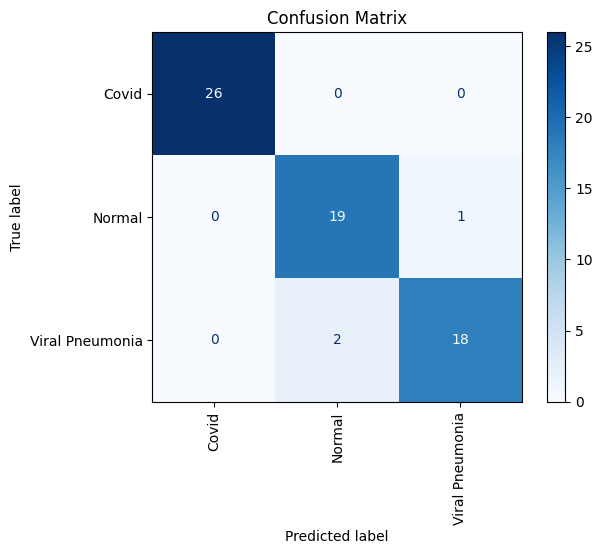

In [ ]:
y_true = []
y_pred = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        outputs = vgg16(x_test)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_test.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# covid = 25
# Normal = 19
# Pneumonia = 19
# t = 64

# Save a Trained VGG16 Model in our own datasets

In [ ]:
torch.save(vgg16.state_dict(), '/content/drive/MyDrive/AIML Final Projects/Covid19 Xray CNN Models 2.pth')
print("Model saved to Google Drive")

Model saved to Google Drive


# Load a Trained models

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

num_classes = 3

model = models.vgg16(pretrained=False)

model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
state_dict = torch.load("/content/drive/MyDrive/AIML Final Projects/Covid19 Xray CNN Models 2.pth", map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()  # Set to evaluation mode

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
from google.colab import files
files.download("Covid19 Xray CNN Model.pth")
print("Model Is Saved")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model Is Saved


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the model directly to Drive
torch.save(vgg16.state_dict(), '/content/drive/MyDrive/AIML Final Projects/Covid19 Xray CNN Model Final.pth')
print("Model saved to Google Drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Google Drive
